## Context

There are billions of text data being generated everyday. Text data, even though, it is easy to understand for most people (as long as you know the language), **it requires a lot of manpower to analyse a large of volume of text data** that is being generated online on platforms such as Facebook, Instagram, e-commerce platforms such as Amazon, Lazada and Shopee. Hence, it is becoming increasingly important for these companies to analyse these consumers-generated complains and opinions. Because of these reasons, Natural Language Processing (NLP) has been gaining a lot of attention. With the help of NLP, machines are able to detect keywords and phrases and even sentiments of the phrases.

However, there are still **many challenges in the NLP field. Even though there has been several breakthrough in the recent years, it is still challenging for most NLP techniques to detect sarcasm, negation words and to understand the context of a large chunk of texts.** Hence, this project will attempt to do do reviews mining, mainly to extract important features within a review and also, the sentiment of the feature. 

**For example, if a reviewer says that "I recently bought this phone. It has a great camera, but I don't like the screen". We will attempt to extract the sentiment for each feature, namely camera and screen in this context (positive for camera and negative for screen). We will also try to overcome the negation factor as many sentiment analysis techniques such as "VADER" would most likely predict the sentiment towards screen as positive due to the word "like".**

How NLP can impact businesses:
1. Improve customers experience by learning more about customer's complains
2. Improve sales directly by highlighting features that are important to customers in the product description
3. Improve user interface and platform experience by segregating reviews into topics or summarising long reviews into just the main points/features and their corresponding sentiments.

## Approach

The dataset used for this project was taken  from a [Kaggle listing](https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews/version/2). The reviews were crawled from Amazon US site. It has **more than 60,000 reviews on 720 different types of phones.** 


We will first perform **topic modelling using Latent Dirichlet allocation (LDA) algorithm** to understand the topics of the reviews (what do reviewers usually talk about). Using the dominant topics that we have obtained from LDA, we will **extract the features from the reviews and attempt to predict the sentiment towards that particular feature** as elaborated in the above example. We will compare three different techniques, namely: **Logistic Regression Classifier, Valence Aware Dictionary and Sentiment Reasoner (VADER) and Bidirectional Encoder Representations from Transformers(BERT).** BERT is considered as a state of the art NLP technique that has been published by researched at Google AI Language. Google has also announced that it has updated its search engine with BERT algorithm.

## Problem Statement


The scope of this project would be to improve user interface and platform experience by:

1. Automatically segregates reviews by topics
2. Extract product features and sentiments within a review

## Content 

**Notebook 1: 1_data_cleaning_and_eda**
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Text Data Pre-processing](#Reviews-Pre-processing)

**Notebook 2: 2_reviews_topic modelling**
- Data Import
- Topic Modelling with Gensim

**Notebook 3: 3_topic_analysis_and_visualizations**
- Findings and Analysis of Topic Modelling

**Notebook 4: 4_features_extractions_and_sentiment_analysis**
- Data Import
- Sentiment Analysis with VADER
- Sentiment Analysis with Logistic Regression(Multi-Class Classification)
- Evaluation of Sentiment Analysis with BERT(Multi-Class Classification)
Please refer to notebook 5 for the fine-tuning process of pre-trained BERT model


**Notebook 5: 5_fine_tuning_of_BERT_model**   
The reason why this notebook is separated from notebook 4 which contains the evaluation of BERT model is because the fine-tuning of BERT model requires GPU. Hence, the model was fine-tuned on Google Colaboratory and loaded back into notebook 4 for evaluation


**Notebook 6: 6_analysis_and_findings**
- Comparison of the 3 Methods 
- Recommendation and Conclusion 
- Future Steps

## Data Import and Cleaning

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('default')
%matplotlib inline

#pd.set_option('display.max_colwidth',None)

There are two csv files that we need to read in:
1. Reviews - containing 67986 reviews 
2. Items - containing 720 unique cellphones across different brands

In [2]:
#reading in the data 
reviews = pd.read_csv('../data/amazon_cells_v2.csv')
items = pd.read_csv('../data/amazon_items_v2.csv')

In [3]:
#confirming the shape of reviews dataframe 
reviews.shape

(67986, 8)

In [4]:
#confirming the shape of items dataframe 
items.shape

(720, 10)

In [5]:
#the columns/information that reviews dataframe contains
reviews.columns

Index(['asin', 'name', 'rating', 'date', 'verified', 'title', 'body',
       'helpfulVotes'],
      dtype='object')

In [6]:
#the columns/information that items dataframe contains
items.columns

Index(['asin', 'brand', 'title', 'url', 'image', 'rating', 'reviewUrl',
       'totalReviews', 'price', 'originalPrice'],
      dtype='object')

In [7]:
#renaming the two title columns to avoid confusion since they mean different things 
#and we are going to merge them 
items.rename(columns={'title':'item_title'},inplace=True)
reviews.rename(columns={'title':'review_title'},inplace=True)

In [8]:
#to avoid confusion we are also dropping the ratings that is found on item as thats the overall rating per item 
#what we want is the rating for every review hence, we will keep the rating column found on reviews dataframe 
items.drop('rating',axis=1,inplace=True)
items.shape

(720, 9)

In [9]:
#check for duplicates 
reviews.duplicated(subset=['name','asin','date','review_title','body']).sum()

39

In [10]:
#drop duplicates
reviews.drop_duplicates(subset=['name','asin','date','review_title','body'],keep='first',inplace=True)
#check shape to confirm 
reviews.shape

(67947, 8)

In [11]:
#merge the two dataframes 
new_reviews = pd.merge(reviews,items,on='asin',how='left')

In [45]:
new_reviews.columns

Index(['asin', 'name', 'rating', 'date', 'verified', 'review_title', 'body',
       'helpfulVotes', 'brand', 'item_title', 'url', 'image', 'reviewUrl',
       'totalReviews', 'price', 'originalPrice', 'reviews', 'word_count',
       'cleaned_reviews', 'multi_class_sentiment', 'tokens'],
      dtype='object')

In [49]:
new_reviews.head(2)

,asin,name,rating,date,verified,review_title,body,helpfulVotes,brand,item_title,...,image,reviewUrl,totalReviews,price,originalPrice,reviews,word_count,cleaned_reviews,multi_class_sentiment,tokens
0,B0000SX2UC,Janet,3,2005-10-11,False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,...,https://m.media-amazon.com/images/I/2143EBQ210...,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0,"Def not best, but not worst I had the Samsung ...",333,def best worst awhile absolute doo doo read re...,1,"[def, best, worst, awhile, absolute, doo, doo,..."
1,B0000SX2UC,Luke Wyatt,1,2004-01-07,False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,...,https://m.media-amazon.com/images/I/2143EBQ210...,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0,Text Messaging Doesn't Work Due to a software ...,133,text messaging work due software issue nokia s...,0,"[text, messaging, work, due, software, issue, ..."


In [52]:
new_reviews['image'][0]

'https://m.media-amazon.com/images/I/2143EBQ210L._AC_UY218_ML3_.jpg'

In [50]:
new_reviews.dtypes

asin                             object
name                             object
rating                            int64
date                     datetime64[ns]
verified                           bool
review_title                     object
body                             object
helpfulVotes                    float64
brand                            object
item_title                       object
url                              object
image                            object
reviewUrl                        object
totalReviews                      int64
price                           float64
originalPrice                   float64
reviews                          object
word_count                        int64
cleaned_reviews                  object
multi_class_sentiment             int64
tokens                           object
dtype: object

In [12]:
#converting the date column to the right datatype
new_reviews['date'] = pd.to_datetime(new_reviews['date'])

## Exploratory Data Analysis

In [13]:
#find the latest review by date
new_reviews['date'].max()

Timestamp('2019-12-25 00:00:00')

In [14]:
#find the earliest review by date
new_reviews['date'].min()

Timestamp('2003-11-24 00:00:00')

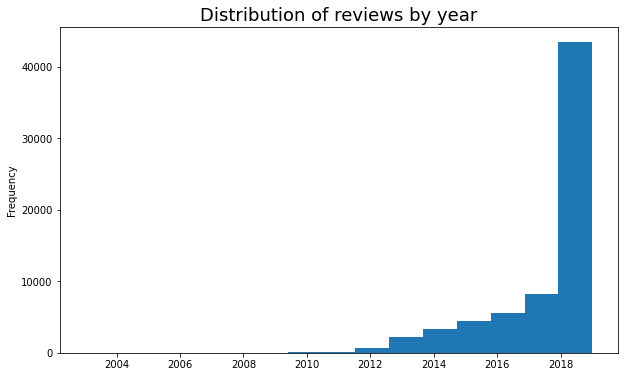

In [15]:
#Set the figuresize
plt.figure(figsize=(10,6))

#plotting the distribution of reviews 
new_reviews['date'].dt.year.plot.hist(bins=15)
plt.title("Distribution of reviews by year",fontsize=18)
plt.show()

From the timestamp and plot above, we can see that the reviews were collected **from November 2003 all the way to December 2019.** Most of the reviews are **from year 2018 and 2019.**

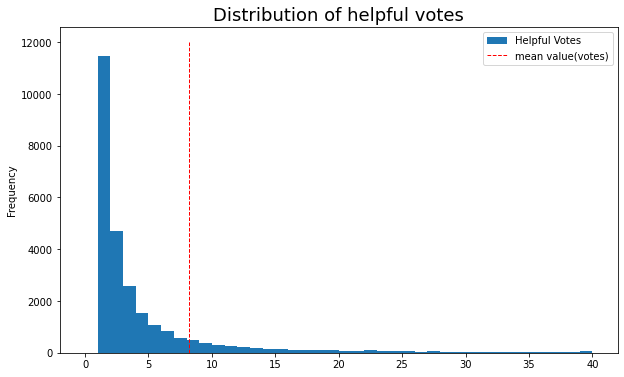

In [17]:
#Set the figuresize
plt.figure(figsize=(10,6))

reviews['helpfulVotes'].plot.hist(label='Helpful Votes',range=(0,40),bins=40)

#set the mean line
plt.vlines(np.mean(reviews['helpfulVotes']), ymin = 0, ymax = 12000,
           color='red', label = 'mean value(votes)',linestyle= '--', lw=1)

plt.legend()
plt.title("Distribution of helpful votes",fontsize=18)
plt.show()

Helpful votes mean that the reviews are found to be helpful by other consumers. The mean value is about 8. However, we can also see that most of the reviews were not rated helpful. This helpful vote can be used as a ranking order in displaying reviews since most people read reviews because they are interested in that particular product. 

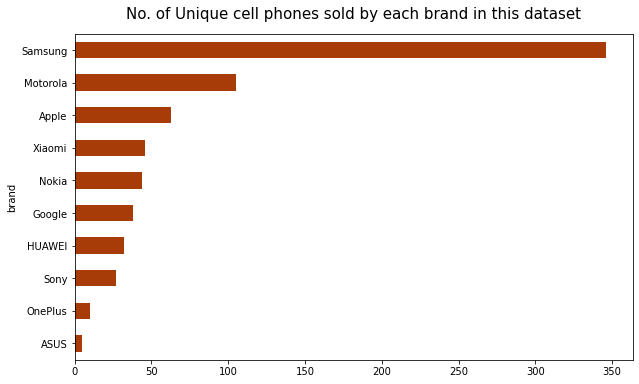

In [18]:
#plot the number of item by brand
items.groupby('brand')['asin'].count().sort_values().plot(kind='barh',
                                                          figsize=(10,6),
                                                         color='xkcd:rust')


plt.title("No. of Unique cell phones sold by each brand in this dataset",fontsize=15,pad=15)
plt.show()

From the items dataframe, we can see that almost half of the cellphones are Samsung phones. Correspondingly, we have the most number of reviews on Samsung phones as shown below.

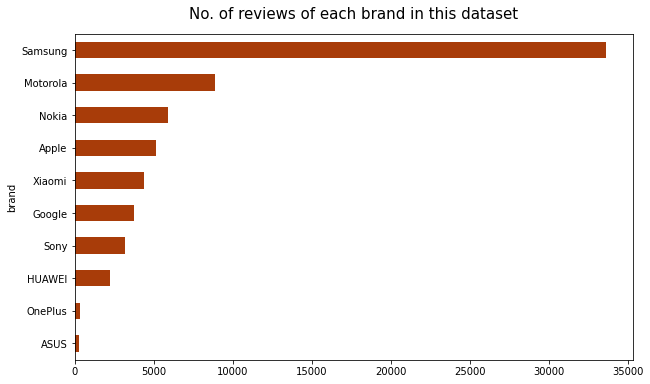

In [19]:
#plot the number of reviews by brand
new_reviews.groupby('brand')['asin'].count().sort_values().plot(kind='barh',
                                                          figsize=(10,6),
                                                         color='xkcd:rust')

plt.title("No. of reviews of each brand in this dataset",fontsize=15,pad=15)
plt.show()

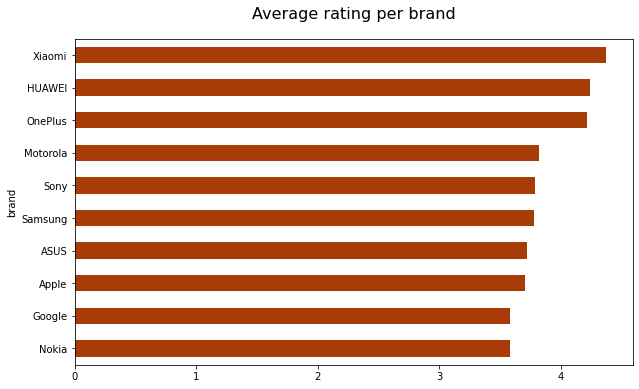

In [20]:
#plot the average rating of each brand 
new_reviews.groupby('brand')['rating'].mean().sort_values().plot(kind='barh',
                                                          figsize=(10,6),
                                                          color='xkcd:rust')


plt.title("Average rating per brand",fontsize=16,pad=20)
plt.show()

We can see that Xiaomi has the highest average rating while Nokia has the lowest average rating. 

In [21]:
def all_text(row):
    """ a function to merge the title and selftext of the posts"""
    row['reviews'] = str(row['review_title']) + " " + str(row['body'])
    return row

In [22]:
#applying the function to the merged dataframe 
new_reviews= new_reviews.apply(all_text, axis=1)

In [23]:
#find the wordcount of each review
new_reviews['word_count'] = new_reviews['reviews'].apply(lambda x: len(str(x).split()))

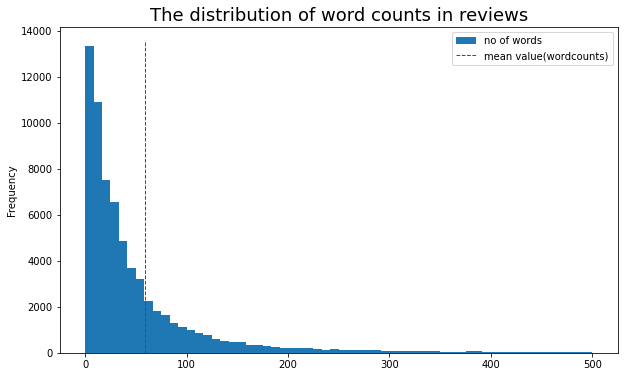

In [24]:
#Set figure size
plt.figure(figsize=(10,6))

#plot the distribution of wordcount
new_reviews['word_count'].plot.hist(label='no of words',range=(0,500),bins=60)


#set the mean line
plt.vlines(np.mean(new_reviews['word_count']), ymin = 0, ymax = 13500,
           color='red', label = 'mean value(wordcounts)',linestyle= '--', lw=1)


plt.title("The distribution of word counts in reviews",fontsize=18)
plt.legend()
plt.show()

In [25]:
#The average wordcount
np.mean(new_reviews['word_count'])

59.51319410717176

We can see that the average wordcount is about 60 words per review. However, the majority of the reviews are less than 60 words. In fact, many fall below 10 words. Let's take a look at some reviews that have less than 10 words.

In [26]:
new_reviews[new_reviews['word_count']<=10]['reviews'].sample(5)

27629                         Five Stars Great phone
8810            Four Stars Product was as described.
7871     Great phone. Came as expected. Great phone.
13414                                     Great Good
23072                                Four Stars good
Name: reviews, dtype: object

We can see that most of these reviews aren't exactly helpful. Let's see whats the distribution of word count in helpful votes. Assuming reviews with above 10 votes are considered helpful.

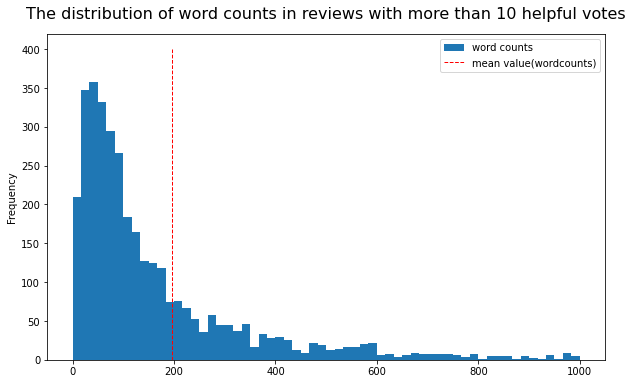

In [27]:
#Set figure size
plt.figure(figsize=(10,6))

new_reviews[new_reviews['helpfulVotes']>=10]['word_count'].plot.hist(label='word counts',
                                                                     range=(0,1000),
                                                                     bins=60)


#set the mean line
mean_value = np.mean(new_reviews[new_reviews['helpfulVotes']>=10]['word_count'])
plt.vlines(mean_value, ymin = 0, ymax = 400,
color='red', label = 'mean value(wordcounts)',linestyle= '--', lw=1)

plt.title("The distribution of word counts in reviews with more than 10 helpful votes",fontsize=16,pad=15)
plt.legend()
plt.show()

We can see that reviews that were voted as helpful has a much higher word count. Both the mode and mean value shifted quite significantly to the right.

## EDA (Text Data)

Over here, we will do the first round of text data cleaning that will be useful for topic modelling later on. However, the main purpose of this section is to gain some insights of our text data through EDA. 

In [28]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

As we have a huge dataset, I will explore the top 4 brands, namely Samsung, Motorola, Apple and Xiaomi

In [29]:
samsung_reviews = new_reviews[new_reviews['brand']=='Samsung']
motorola_reviews = new_reviews[new_reviews['brand']=='Motorola']
apple_reviews = new_reviews[new_reviews['brand']=='Apple']
xiaomi_reviews = new_reviews[new_reviews['brand']=='Xiaomi']

In [30]:
stop_words = stopwords.words('english')
len(stop_words)

179

In [31]:
#add more stopwords 
add_words = ['phone','one','two','three','four','five','star',
             'great','good','moto','el','la','de','motorola','samsung','galaxy']

stop_words.extend(add_words)

In [32]:
#confirm that stopwords have been added
len(stop_words)

195

In [33]:
def clean_reviews(raw_text):
    """
    Function to convert a raw review to a string of words that have been cleaned. 
    - HTML, non-letters will be removed
    - words will be converted to lowercase
    - stopwords will be removed 
    - words will be stemmed to their root words
    
    The input is a single string, and 
    the output is a single string 
    
    """
    
    # Remove HTML.
    post_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # convert the stopwords to a set.
    stops = set(stop_words)
    
    # Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # Stemming 
    #p_stemmer = PorterStemmer()
    #meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    
    #Lemmatize
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(word) for word in 
                        meaningful_words]
    
    # Remove stopwords again after lemmatizing
    meaningful_words = [w for w in meaningful_words if w not in stops]
    
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [34]:
cleaned_reviews = []

print("Cleaning and parsing all reviews...")

# Instantiate counter.
j = 0

# For every review in our combined dataframe

for review in new_reviews['reviews']:
    
    # Apply the function that we created earlier to clean the reviews
    cleaned_reviews.append(clean_reviews(review))
    j += 1
    
print("Completed")

Cleaning and parsing all reviews...
Completed


In [35]:
new_reviews['cleaned_reviews'] = cleaned_reviews

In [36]:
samsung_cleaned_reviews = []

print("Cleaning and parsing samsung reviews...")

# Instantiate counter.
j = 0

# For every review in our combined dataframe

for review in samsung_reviews['reviews']:
    
    # Apply the function that we created earlier to clean the reviews
    samsung_cleaned_reviews.append(clean_reviews(review))
    j += 1
    
print("Completed")

#Repeating the same steps for the other brands
motorola_cleaned_reviews = []
print("Cleaning and parsing motorola reviews...")
j = 0
for review in motorola_reviews['reviews']:
    motorola_cleaned_reviews.append(clean_reviews(review))
    j += 1
print("Completed")


#Repeating the same steps for the other brands
apple_cleaned_reviews = []
print("Cleaning and parsing apple reviews...")
j = 0
for review in apple_reviews['reviews']:
    apple_cleaned_reviews.append(clean_reviews(review))
    j += 1
print("Completed")

#Repeating the same steps for the other brands
xiaomi_cleaned_reviews = []
print("Cleaning and parsing xiaomi reviews...")
j = 0
for review in xiaomi_reviews['reviews']:
    xiaomi_cleaned_reviews.append(clean_reviews(review))
    j += 1
print("Completed")

Cleaning and parsing samsung reviews...
Completed
Cleaning and parsing motorola reviews...
Completed
Cleaning and parsing apple reviews...
Completed
Cleaning and parsing xiaomi reviews...
Completed


In [37]:
def get_one_gram(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_phrase(corpus, n=None):
    """
    List the top n phrases in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(ngram_range=(2, 4)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
#get the most frequently occuring words/phrases in the top 4 brands 
top_samsung_words = dict(get_one_gram(samsung_cleaned_reviews,20))
top_samsung_phrase = dict(get_phrase(samsung_cleaned_reviews,20))

top_motorola_words = dict(get_one_gram(motorola_cleaned_reviews,20))
top_motorola_phrase = dict(get_phrase(motorola_cleaned_reviews,20))

top_apple_words = dict(get_one_gram(apple_cleaned_reviews,20))
top_apple_phrase = dict(get_phrase(apple_cleaned_reviews,20))

top_xiaomi_words = dict(get_one_gram(xiaomi_cleaned_reviews,20))
top_xiaomi_phrase = dict(get_phrase(xiaomi_cleaned_reviews,20))

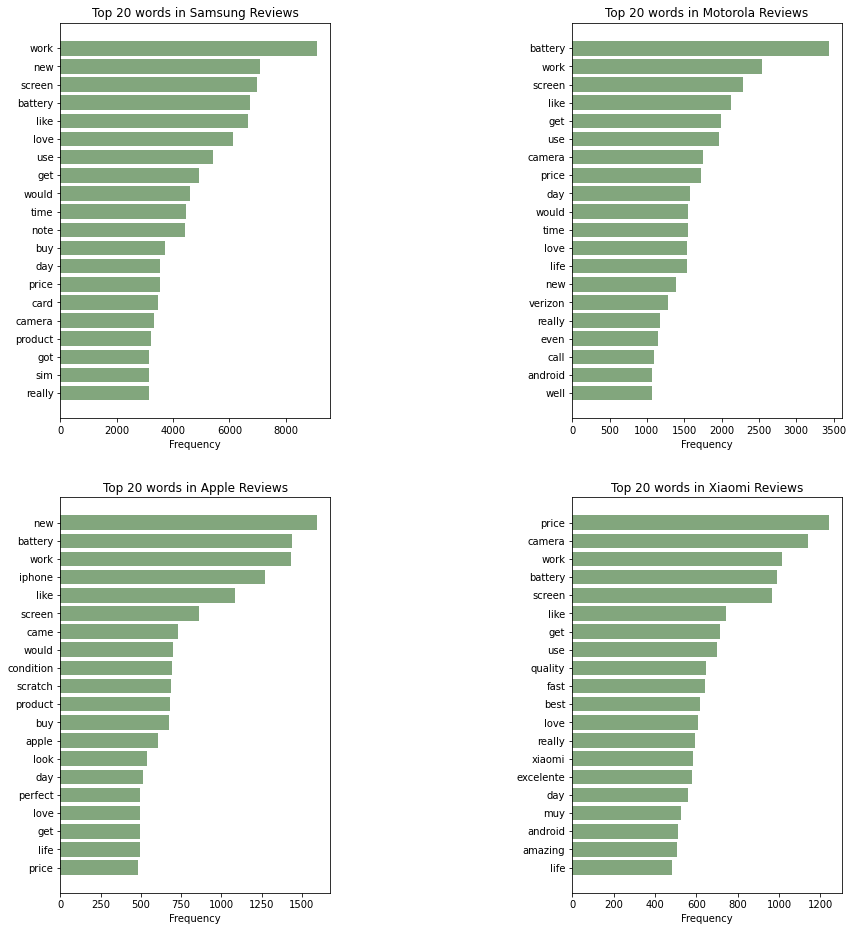

In [39]:
#Create subplots
fig, axes = plt.subplots(2,2, figsize=(14,16));

#plot samsung reviews top 20 most frequently occuring words
plt.subplot(2,2,1)
samsung = plt.barh(range(len(top_samsung_words)), top_samsung_words.values(),align = 'center',color='xkcd:greyish green');
#Label axes 
plt.yticks(range(len(top_samsung_words)),top_samsung_words.keys(),fontsize=10);
plt.title('Top 20 words in Samsung Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot motorola reviews top 20 most frequently occuring words
plt.subplot(2,2,2)
motorola = plt.barh(range(len(top_motorola_words)), top_motorola_words.values(),align = 'center',color='xkcd:greyish green');
#Label axes 
plt.yticks(range(len(top_motorola_words)),top_motorola_words.keys(),fontsize=10);
plt.title('Top 20 words in Motorola Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot apple reviews top 20 most frequently occuring words
plt.subplot(2,2,3)
apple = plt.barh(range(len(top_apple_words)), top_apple_words.values(),align = 'center',color='xkcd:greyish green');
#Label axes
plt.yticks(range(len(top_apple_words)),top_apple_words.keys(),fontsize=10);
plt.title('Top 20 words in Apple Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot xiaomi reviews top 20 most frequently occuring words
plt.subplot(2,2,4)
xiaomi = plt.barh(range(len(top_xiaomi_words)), top_xiaomi_words.values(),align = 'center',color='xkcd:greyish green');

#Label axes
plt.yticks(range(len(top_xiaomi_words)),top_xiaomi_words.keys(),fontsize=10);
plt.title('Top 20 words in Xiaomi Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


plt.subplots_adjust(wspace=0.9)
plt.show()

From the most frequently occuring words, it seems that **people usually talk about camera, battery, screen, condition and price** This trend is consistent across all the 4 brands. Also, the reason why people talk about condition is because Amazon also sell used phones. Hence, condition is also a hot topic to be discussed when it comes to used phones. 

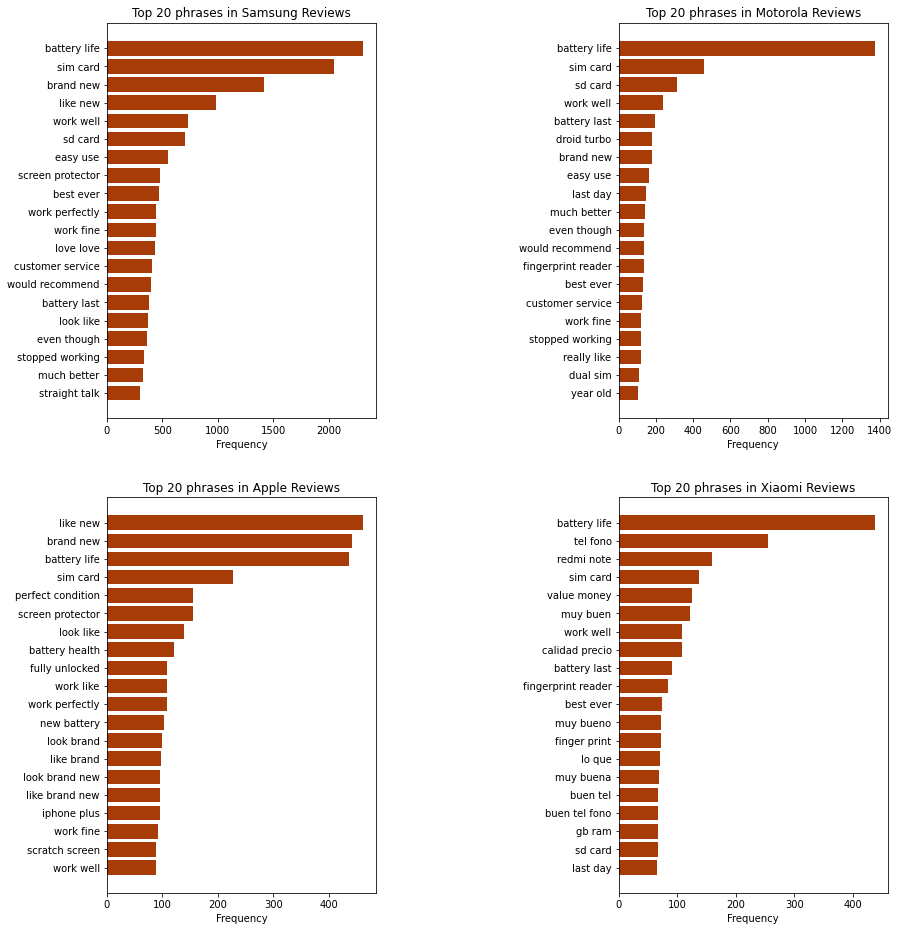

In [40]:
#Create subplots
fig, axes = plt.subplots(2,2, figsize=(14,16));

#plot samsung reviews top 20 most frequently occuring phrases
plt.subplot(2,2,1)
samsung = plt.barh(range(len(top_samsung_phrase)), top_samsung_phrase.values(),align = 'center',color='xkcd:rust');
#Label axes 
plt.yticks(range(len(top_samsung_phrase)),top_samsung_phrase.keys(),fontsize=10);
plt.title('Top 20 phrases in Samsung Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot motorola reviews top 20 most frequently occuring phrases
plt.subplot(2,2,2)
motorola = plt.barh(range(len(top_motorola_phrase)), top_motorola_phrase.values(),align = 'center',color='xkcd:rust');
#Label axes 
plt.yticks(range(len(top_motorola_phrase)),top_motorola_phrase.keys(),fontsize=10);
plt.title('Top 20 phrases in Motorola Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot apple reviews top 20 most frequently occuring phrases
plt.subplot(2,2,3)
apple = plt.barh(range(len(top_apple_phrase)), top_apple_phrase.values(),align = 'center',color='xkcd:rust');
#Label axes
plt.yticks(range(len(top_apple_phrase)),top_apple_phrase.keys(),fontsize=10);
plt.title('Top 20 phrases in Apple Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


#plot xiaomi reviews top 20 most frequently occuring phrases
plt.subplot(2,2,4)
xiaomi = plt.barh(range(len(top_xiaomi_phrase)), top_xiaomi_phrase.values(),align = 'center',color='xkcd:rust');

#Label axes
plt.yticks(range(len(top_xiaomi_phrase)),top_xiaomi_phrase.keys(),fontsize=10);
plt.title('Top 20 phrases in Xiaomi Reviews')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()


plt.subplots_adjust(wspace=0.9)
plt.show()

Again, the most frequently phrases also show that people talk about battery life/battery health/battery last. It also talks about dual sim feature and mostly describing if the condition of the phone.  

Another observation is that there seems to a huge amount of Spanish phrases in xiaomi reviews. 

Next, we will move on to doing topic modelling and sentiment predictions. Before that, I would like to convert the **ratings to just 3 classes: positive, negative and neutral.** Reason is that rating 4 and 5 can be extremely similar and subjective to individual's judgement. Hence, to avoid this ambiguity, we will go with positive, neutral and negative. 

In [41]:
def multi_class_sentiment(rating):
    if rating >= 4:
        return 2 #positive 
    elif rating == 3:
        return 1 #neutral
    else:
        return 0 #negative
    

new_reviews['multi_class_sentiment'] = new_reviews['rating'].map(multi_class_sentiment)

In [42]:
#splitting the cleaned reviews into tokens will be useful for topic modelling later on 
new_reviews['tokens'] = new_reviews['cleaned_reviews'].map(lambda x:x.split())

In [43]:
#confirming the shape before we export the dataframe to csv file. 
new_reviews.shape

(67947, 21)

Finally, we will save the model. I have changed it to comment instead because I do not want to accidentally overwrite the file while working on the notebook. 

In [44]:
#new_reviews.to_csv('../data/cleaned_combined_data.csv',index=False)